# JPEG compression regressor


In this little project, the aim is to regress whether and at what extent an image has been JPEG
compressed. JPEG compression uses discrete cosine transform to quantize higher frequencies in 8x8 windows.


This project tends to use frequency domain to analyze whether an image has been compressed. A RandomForestRegressor
is trained on eingenvalues from mean spectrum of all 8x8 patches from an image. 

To ensure space robustness,
eigenvalues are extracted also from shifted patches.


### NOTE
It is indeed possible to use approaches found in literature, but I found this task can be taken from a custom
and more fun perspective.

In [1]:
from typing import Tuple

import cv2
import einops
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision.io import encode_jpeg, read_image, write_png, ImageReadMode


class SplitPatch:
    
    def __init__(self, window_size: Tuple[int, int]):
        self.window_size = window_size
        
    def __call__(self, image):
        return einops.rearrange(image, "c (h i) (w k) -> (h w c) i k", i=self.window_size[0], k=self.window_size[1])


def simulate_jpeg_compression(image: np.ndarray, jpeg_quality: int = 100) -> np.ndarray:
    compressed_image = image.copy()
    *_, encoded = cv2.imencode(".jpg", compressed_image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])
    return cv2.imdecode(encoded, 1)


def fourier_transform_method(splitter, image):
    fft = torch.fft.fft2(splitter(image))
    fft = torch.abs(fft)
    return fft


def extract_features(fft):
    return torch.abs(torch.linalg.eigvals(fft).median(0)).numpy()


def process_image(image):
    image = torch.from_numpy(image).permute(2, 0, 1)
    splitter = SplitPatch((8, 8))
    return extract_features(fourier_transform_method(splitter, image))


def process_image_with_shift(image):
    feats = []
    image = torch.from_numpy(image).permute(2, 0, 1)

    for shift in range(8):
        splitter = SplitPatch((8, 8))
        feats.append(extract_features(fourier_transform_method(
            splitter, torch.roll(image, shifts=(-shift, -shift), dims=(-1, -2)))))
    return torch.from_numpy(np.array(feats)).flatten()


def pca(tensor, n_components=3):
    assert tensor.shape[1] < tensor.shape[0]
    cov_mat = torch.matmul(tensor.transpose(0, 1), tensor) / (tensor.shape[0] - 1)
    eigen = torch.eig(cov_mat, eigenvectors=True)
    return torch.matmul(tensor, eigen[1][:, :n_components])


## Example of image + its patch eigenvalues sum (in frequency domain)

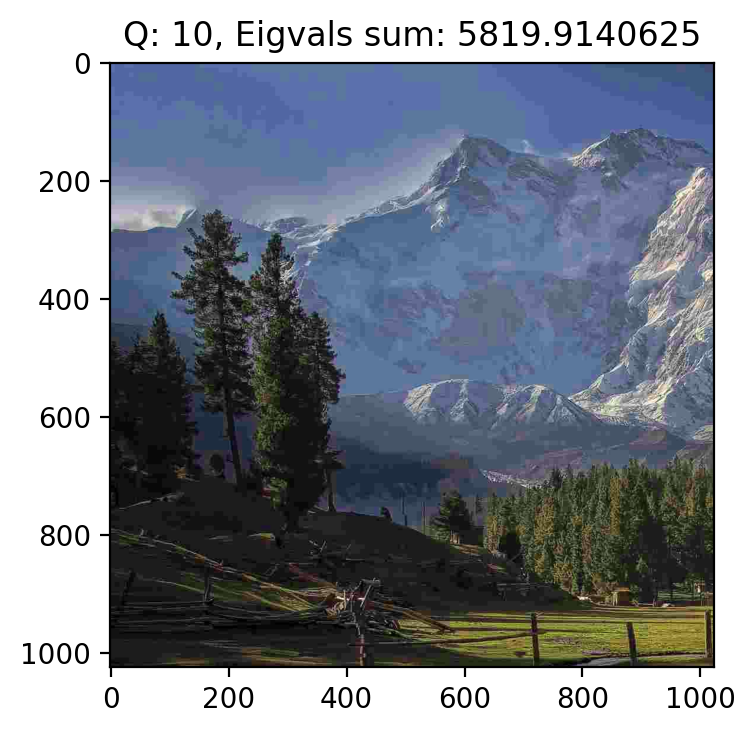

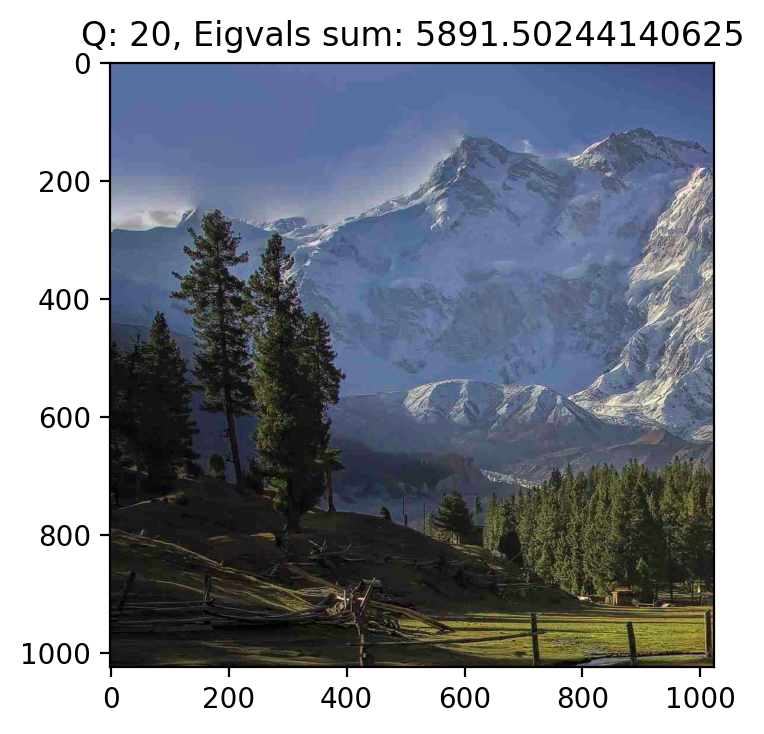

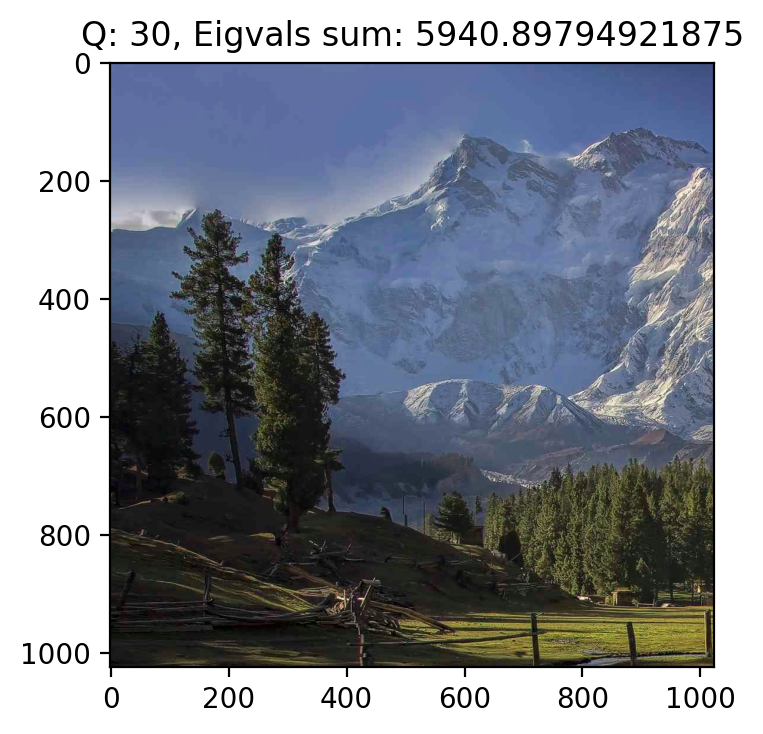

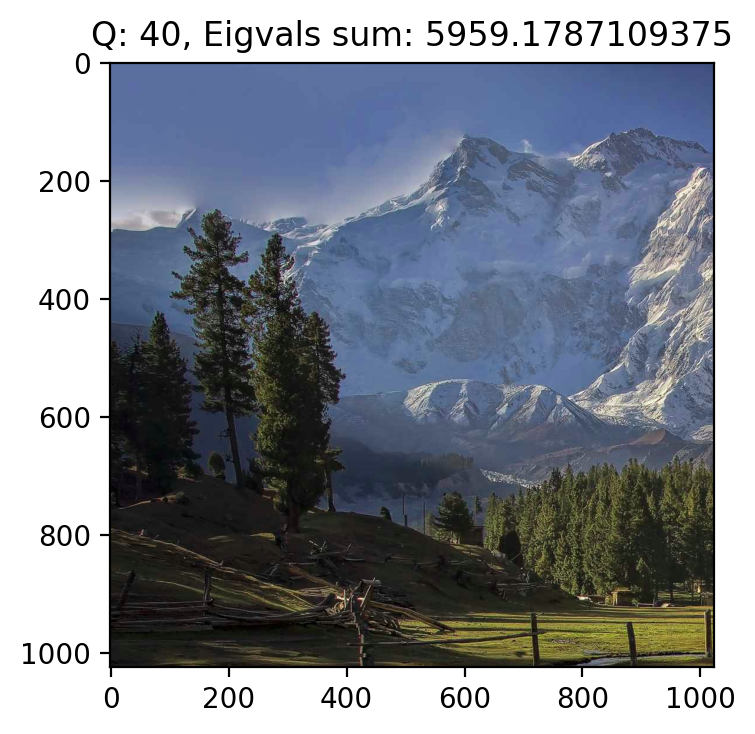

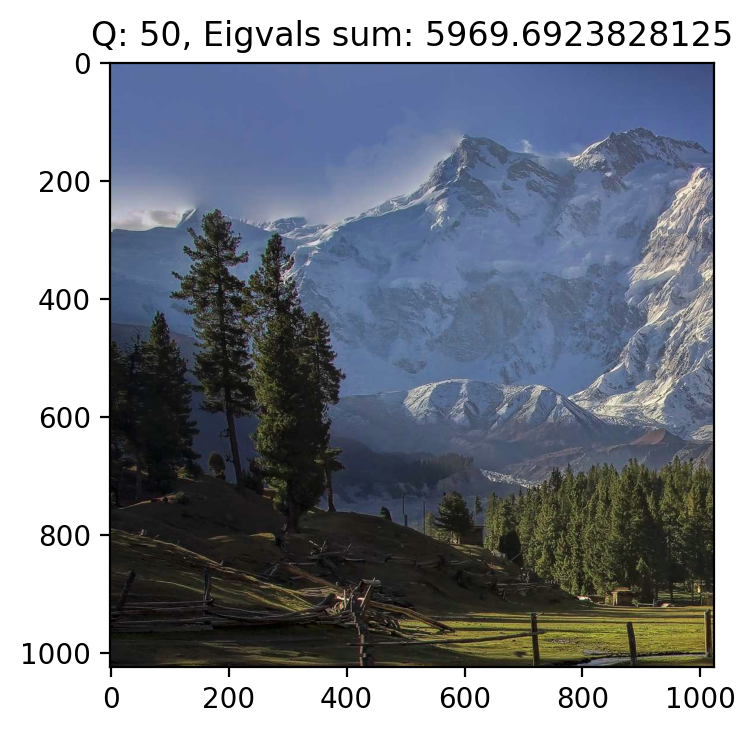

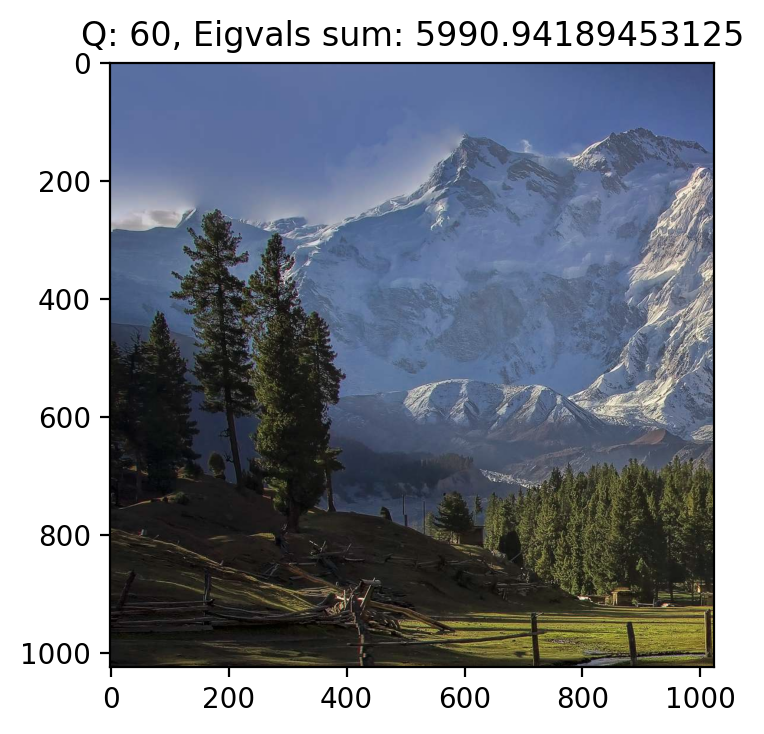

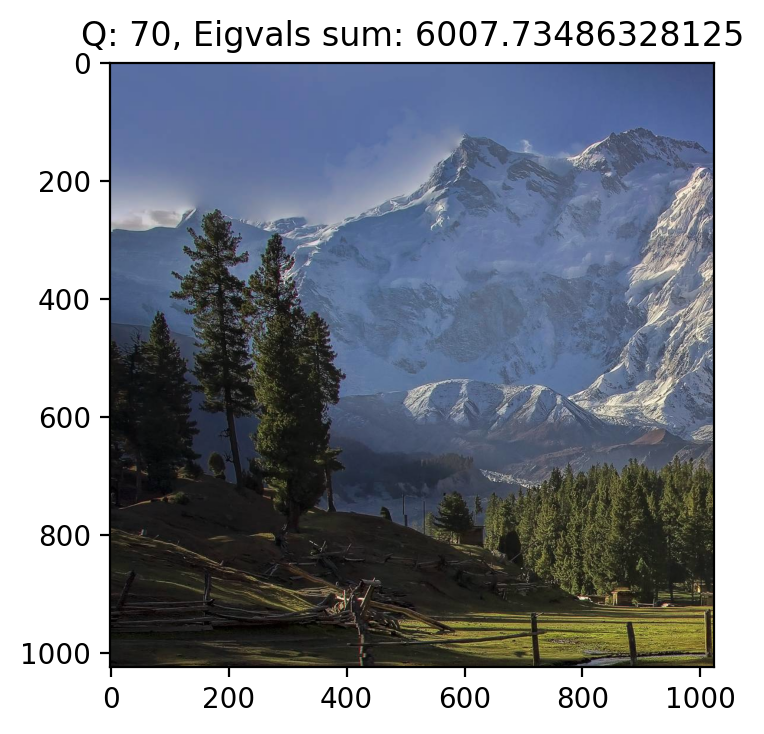

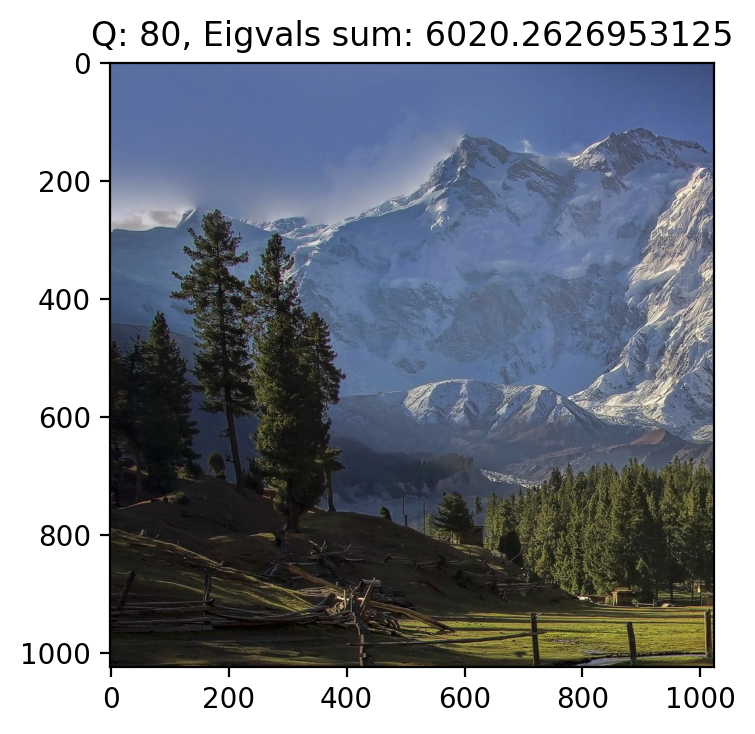

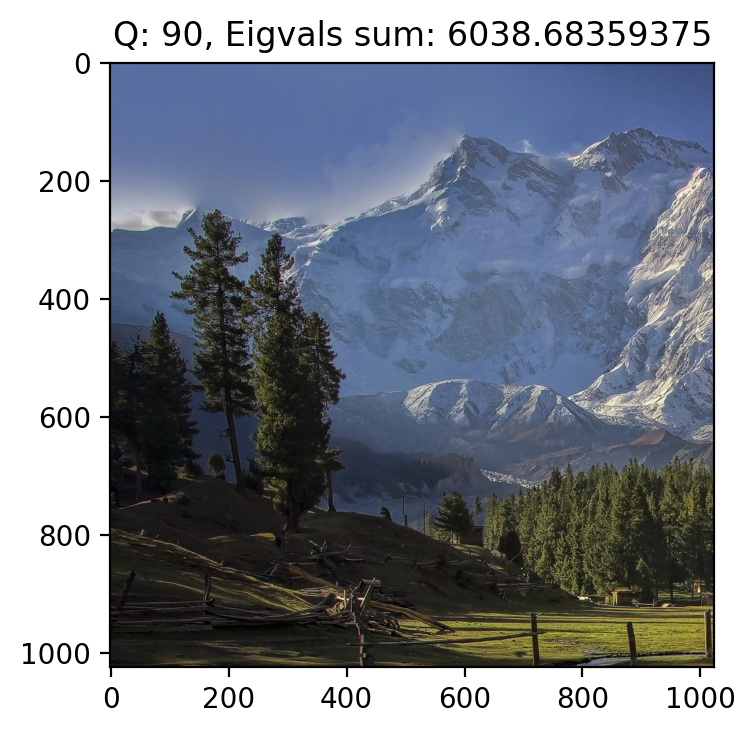

In [66]:
values = []
image = read_image("./data/val_dataset/0002.png", mode=ImageReadMode.RGB)[:, :1024, :1024]
for quality in range(10, 100, 10):
    compressed_image = torch.from_numpy(simulate_jpeg_compression(image.permute(1, 2, 0).numpy(), jpeg_quality=quality)).permute(2, 0, 1)
    write_png(compressed_image, "a.png")
    fourier = fourier_transform_method(SplitPatch((8, 8)), image)
    compressed_fourier = fourier_transform_method(SplitPatch((8, 8)), compressed_image)
    values.append((compressed_image, f"Q: {quality}, Eigvals sum: {np.sum(extract_features(compressed_fourier))}"))

    
for idx, value in enumerate(values):
    plt.figure(dpi=200)
    plt.imshow(value[0].permute(1, 2, 0).numpy())
    plt.title(value[1])
    plt.show()

In [2]:
from collections import namedtuple
import glob
import os
import random
from typing import Callable, Union

import cv2
import torch
import torch.utils.data as data


RandomMinMax = namedtuple("RandomMinMax", ["min", "max"])


class SimpleClassificationDataset(data.Dataset):
    
    def __init__(self, image_folder, transforms: Callable, compression_probability: float = 0.8, 
                 jpeg_quality: RandomMinMax = RandomMinMax(min=20, max=95), image_shape: Union[None, Tuple] = None):
        self.images = glob.glob(os.path.join(image_folder, "*"))
        self.transforms = transforms
        self.compression_probability = compression_probability
        self.jpeg_quality = jpeg_quality
        self.image_shape = image_shape
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = cv2.imread(self.images[item])
        if self.image_shape is not None:
            image = cv2.resize(image, self.image_shape, interpolation=cv2.INTER_LINEAR)
        if is_compression := (random.random() < self.compression_probability):
            compression_level = random.randint(self.jpeg_quality.min, self.jpeg_quality.max)
            image = simulate_jpeg_compression(image, jpeg_quality=compression_level)
        else:
            compression_level = 100
        image = self.transforms(image)
        return image, torch.tensor([is_compression]).long(), compression_level, self.images[item]

## Train simple RandomForestRegressor from sklearn

In [3]:
from typing import Callable, Iterable

from sklearn.ensemble import RandomForestRegressor


def create_dataset(dataset: Iterable, extraction_function: Callable, features_length: int = 8):
    
    feats = np.zeros((len(dataset), features_length))
    targets = np.zeros((len(dataset)))
    
    for idx, (image, is_compressed, compression_level, path) in enumerate(dataset):
        features = extraction_function(image)
        feats[idx, :] = features
        targets[idx] = compression_level
    
    return feats, targets

dataset = SimpleClassificationDataset("./data/DIV2K_train_HR", lambda x: x, image_shape=(1024, 1024))
samples, targets = create_dataset(
    dataset, 
    process_image_with_shift, 
    64)
regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(samples, targets)

RandomForestRegressor(n_estimators=20)

## Simple check

In [4]:
import pandas as pd

checks = {"GT": [], "PRED": []}

for idx in range(25):
    sample = dataset[idx]
    features = process_image_with_shift(sample[0])
    pred = regressor.predict(np.expand_dims(features, axis=0))
    checks["GT"].append(sample[2])
    checks["PRED"].append(pred)
    
pd.DataFrame.from_dict(checks)

GT     PRED
0   100  [100.0]
1    86   [72.3]
2    92   [81.6]
3   100  [99.05]
4   100  [100.0]
5    61   [84.4]
6   100  [100.0]
7   100   [98.7]
8    85  [93.65]
9    25  [40.75]
10  100  [97.05]
11   30   [48.8]
12   72  [70.05]
13   93   [98.3]
14  100  [100.0]
15   73  [63.15]
16   90   [99.2]
17   64   [71.0]
18   57  [64.25]
19   74  [53.75]
20  100  [100.0]
21  100  [100.0]
22   32  [37.75]
23   69  [57.85]
24   55   [43.8]

## Inference

Validation test inference and storing it under pandas dataframe.

In [5]:
import os
from typing import Iterable, Callable

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm


def infer_images(regressor: RandomForestRegressor, dataset: Iterable, extraction_function: Callable) -> pd.DataFrame:
    output_dict = {
        "image": [],
        "compression_prediction": []
    }
    for idx in tqdm(range(len(dataset))):
        sample = dataset[idx]
        features = extraction_function(sample[0])
        pred = regressor.predict(np.expand_dims(features, axis=0))
        output_dict["image"].append(os.path.basename(sample[3]))
        output_dict["compression_prediction"].append(pred[0])
    return pd.DataFrame.from_dict(output_dict)


dataset_inference = SimpleClassificationDataset("./data/val_dataset/", lambda x: x, image_shape=(1024, 1024), compression_probability=-1.)
prediction_frame = infer_images(regressor, dataset_inference, process_image_with_shift)
prediction_frame

  0%|          | 0/34 [00:00<?, ?it/s]

image  compression_prediction
0                                      desantnica.png                   62.05
1   8732539_lislleyavila_2020_04_01_05_58_22_CLIQU...                   64.40
2              8725893_PhotoCollage_1585735486638.jpg                   96.40
3   8782597_1F9DC2C3-A67E-4379-A1A6-A0228F939355.jpeg                  100.00
4                                           indus.png                   61.90
5                                         0810_20.jpg                   51.60
6                                        00001_45.png                   66.75
7                                      image (14).png                   96.00
8                                          low_80.jpg                   58.95
9                                low_60_90_killed.jpg                   67.95
10                             look.com.ua-267301.jpg                  100.00
11                                         region.png                   56.35
12               1e8b970f4259424bcf6c79903bb46a41.jpg                   59.00
13          8828824_BodyEditor_20200329_162131317.jpg                   73.80
14                            img_20220110_134535.png                  100.00
15                                         low_60.jpg                   62.85
16                              9014255_hoka-mach.png                   87.25
17                                         slonik.jpg                   59.00
18                             film-grain-overlay.jpg                  100.00
19                                        region2.png                   72.90
20                                     web_low_90.jpg                   83.25
21                                        0810_80.jpg                  100.00
22                                              1.jpg                   60.90
23  olga-boyko-a-warrior-devushka-krasotka-rytsar-...                   87.85
24                              Ref_Image_low res.jpg                   84.30
25                                           ppt3.png                   56.30
26                                            q52.png                   59.75
27                              8873192_199471515.jpg                   70.00
28                            IMG_20220110_133943.png                   93.20
29                                           0002.png                   99.25
30                                  low_90_killed.jpg                   87.15
31                                       00001_20.jpg                   52.20
32                            img_20220107_145854.png                   99.70
33                                 00001_50_70_90.jpg                   66.10

# Approach using neural networks

In this part, Convolutional network is used. Transformer could be used as well, but we think that
convolution may be well suited for this type of task.

Why? Because according to Convolution theorem, convolution is directly assotiated with spectrum and vice versa.